In [238]:
from logging import raiseExceptions
from tokenize import Double
import networkx as nx
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import os
import numpy as np
from vec3 import Vec3
import meshplot as mp
import torch
torch.manual_seed(125)
import random
random.seed(125)
import torch_f

In [239]:
def count_fn(f):
    def wrapper(*args, **kwargs):
        wrapper.count += 1
        return f(*args, **kwargs)
    wrapper.count = 0
    return wrapper

Clase nodo

In [240]:
class Node:
    """
    Class Node
    """
    def __init__(self, value, radius, left = None, right = None, position = None, cl_prob= None, ce = None, mse = None):
        self.left = left
        self.data = value
        self.radius = radius
        self.position = position
        self.right = right
        self.prob = cl_prob
        self.mse = mse
        self.ce = ce
        self.children = [self.left, self.right]
    
    def agregarHijo(self, children):

        if self.right is None:
            self.right = children
        elif self.left is None:
            self.left = children

        else:
            raise ValueError ("solo arbol binario ")


    def is_leaf(self):
        if self.right is None:
            return True
        else:
            return False

    def is_two_child(self):
        if self.right is not None and self.left is not None:
            return True
        else:
            return False

    def is_one_child(self):
        if self.is_two_child():
            return False
        elif self.is_leaf():
            return False
        else:
            return True

    def childs(self):
        if self.is_leaf():
            return 0
        if self.is_one_child():
            return 1
        else:
            return 2
    
    
    def traverseInorder(self, root):
        """
        traverse function will print all the node in the tree.
        """
        if root is not None:
            self.traverseInorder(root.left)
            print (root.data, root.radius)
            self.traverseInorder(root.right)

    def traverseInorderLoss(self, root, loss):
        """
        traverse function will print all the node in the tree.
        """
        if root is not None:
            self.traverseInorderLoss(root.left, loss)
            loss.append(root.prob)
            self.traverseInorderLoss(root.right, loss)
            return loss

    def traverseInorderMSE(self, root, loss):
        """
        traverse function will print all the node in the tree.
        """
        if root is not None:
            self.traverseInorderMSE(root.left, loss)
            loss.append(root.mse)
            self.traverseInorderMSE(root.right, loss)
            return loss

    def traverseInorderCE(self, root, loss):
        """
        traverse function will print all the node in the tree.
        """
        if root is not None:
            self.traverseInorderCE(root.left, loss)
            loss.append(root.ce)
            self.traverseInorderCE(root.right, loss)
            return loss

    def traverseInorderChilds(self, root, l):
        """
        traverse function will print all the node in the tree.
        """
        if root is not None:
            self.traverseInorderChilds(root.left, l)
            l.append(root.childs())
            self.traverseInorderChilds(root.right, l)
            return l

    def preorder(self, root):
        """
        traverse function will print all the node in the tree.
        """
        if root is not None:
            print (root.data, root.radius)
            self.preorder(root.left)
            self.preorder(root.right)

    def cloneBinaryTree(self, root):
     
        # base case
        if root is None:
            return None
    
        # create a new node with the same data as the root node
        root_copy = Node(root.data, root.radius)
    
        # clone the left and right subtree
        root_copy.left = self.cloneBinaryTree(root.left)
        root_copy.right = self.cloneBinaryTree(root.right)
    
        # return cloned root node
        return root_copy

    def height(self, root):
    # Check if the binary tree is empty
        if root is None:
            return 0 
        # Recursively call height of each node
        leftAns = self.height(root.left)
        rightAns = self.height(root.right)
    
        # Return max(leftHeight, rightHeight) at each iteration
        return max(leftAns, rightAns) + 1

    # Print nodes at a current level
    def printCurrentLevel(self, root, level):
        if root is None:
            return
        if level == 1:
            print(root.data, end=" ")
        elif level > 1:
            self.printCurrentLevel(root.left, level-1)
            self.printCurrentLevel(root.right, level-1)

    def printLevelOrder(self, root):
        h = self.height(root)
        for i in range(1, h+1):
            self.printCurrentLevel(root, i)


    
    def count_nodes(self, root, counter):
        if   root is not None:
            self.count_nodes(root.left, counter)
            counter.append(root.data)
            self.count_nodes(root.right, counter)
            return counter

    
    def serialize(self, root):
        def post_order(root):
            if root:
                post_order(root.left)
                post_order(root.right)
                ret[0] += str(root.data)+'_'+ str(root.radius) +';'
                
            else:
                ret[0] += '#;'           

        ret = ['']
        post_order(root)
        return ret[0][:-1]  # remove last ,

    def toGraph( self, graph, index, dec, proc=True):
        
        
        radius = self.radius.cpu().detach().numpy()
        if dec:
            radius= radius[0]
        #print("posicion", self.data, radius)
        #print("right", self.right)
        
        #graph.add_nodes_from( [ (index, {'posicion': radius[0:3], 'radio': radius[3] } ) ])
        graph.add_nodes_from( [ (self.data, {'posicion': radius[0:3], 'radio': radius[3] } ) ])
        

        if self.right is not None:
            #leftIndex = self.right.toGraph( graph, index + 1, dec)#
            self.right.toGraph( graph, index + 1, dec)#
            
            #graph.add_edge( index, index + 1 )
            graph.add_edge( self.data, self.right.data )
            #if proc:
            #    nx.set_edge_attributes( graph, {(index, index+1) : {'procesada':False}})
        
            if self.left is not None:
                #retIndex = self.left.toGraph( graph, leftIndex, dec )#
                self.left.toGraph( graph, 0, dec )#

                #graph.add_edge( index, leftIndex)
                graph.add_edge( self.data, self.left.data)
                #if proc:
                #    nx.set_edge_attributes( graph, {(index, leftIndex) : {'procesada':False}})
            
            else:
                #return leftIndex
                return

        else:
            #return index + 1
            return

Funciones extra

In [241]:
use_gpu = True
device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")

In [242]:
def plotTree( root, dec ):
    graph = nx.Graph()
    root.toGraph( graph, 0, dec)
    edges=nx.get_edge_attributes(graph,'procesada')

    p = mp.plot( np.array([ graph.nodes[v]['posicion'] for v in graph.nodes]), shading={'point_size':0.1}, return_plot=True)

    for arista in graph.edges:
        p.add_lines( graph.nodes[arista[0]]['posicion'], graph.nodes[arista[1]]['posicion'])

    return 

def traverse(root, tree):
       
        if root is not None:
            traverse(root.left, tree)
            tree.append((root.radius, root.data))
            traverse(root.right, tree)
            return tree

def traverse_2(tree1, tree2, t_l):
       
        if tree1 is not None:
            traverse_2(tree1.left, tree2.left, t_l)
            if tree2:
                t_l.append((tree1.radius, tree2.radius))
                print((tree1.radius, tree2.radius))
            else:
                t_l.append(tree1.radius)
                print((tree1.radius))
            traverse_2(tree1.right, tree2, t_l)
            return t_l
            

def traverse_conexiones(root, tree):
        """
        traverse function will print all the node in the tree.
        """
        if root is not None:
            traverse_conexiones(root.left, tree)
            if root.right is not None:
                tree.append((root.data, root.right.data))
            if root.left is not None:
                tree.append((root.data, root.left.data))
            traverse_conexiones(root.right, tree)
            return tree

def arbolAGrafo (nodoRaiz):
    
    conexiones = []
    lineas = traverse_conexiones(nodoRaiz, conexiones)
    tree = []
    tree = traverse(nodoRaiz, tree)

    vertices = []
    verticesCrudos = []
    for node in tree:
        vertice = node[0][0][:3]
        rad = node[0][0][-1]
        num = node[1]
        
        #vertices.append((num, {'posicion': Vec3( vertice[0], vertice[1], vertice[2]), 'radio': rad} ))
        vertices.append((len(verticesCrudos),{'posicion': Vec3( vertice[0], vertice[1], vertice[2]), 'radio': rad}))
        verticesCrudos.append(vertice)


    G = nx.Graph()
    G.add_nodes_from( vertices )
    G.add_edges_from( lineas )
    
    return G

@count_fn
def createNode(data, radius, position = None, left = None, right = None, cl_prob = None, ce = None, mse=None):
        """
        Utility function to create a node.
        """
        return Node(data, radius, position, left, right, cl_prob, ce, mse)
 
def deserialize(data):
    if  not data:
        return 
    nodes = data.split(';')  
    #print("node",nodes[3])
    def post_order(nodes):
                
        if nodes[-1] == '#':
            nodes.pop()
            return None
        node = nodes.pop().split('_')
        data = int(node[0])
        #radius = float(node[1])
        #print("node", node)
        #breakpoint()
        radius = node[1]
        #print("radius", radius)
        rad = radius.split(",")
        rad [0] = rad[0].replace('[','')
        rad [3] = rad[3].replace(']','')
        r = []
        for value in rad:
            r.append(float(value))
        #r =[float(num) for num in radius if num.isdigit()]
        r = torch.tensor(r, device=device)
        #breakpoint()
        root = createNode(data, r)
        root.right = post_order(nodes)
        root.left = post_order(nodes)
        
        return root    
    return post_order(nodes)    


def read_tree(filename):
    with open('./trees/' +filename, "r") as f:
        byte = f.read() 
        return byte

Encoder

In [243]:
class InternalEncoder(nn.Module):
    
    def __init__(self, input_size: int, feature_size: int, hidden_size: int):
        super(InternalEncoder, self).__init__()
        self.l1 = nn.Linear(input_size,hidden_size)
        self.l2 = nn.Linear(hidden_size,feature_size)
        self.l3 = nn.Linear(feature_size,feature_size)

        self.left = nn.Linear(feature_size,feature_size)
        self.right = nn.Linear(feature_size,feature_size)
        
        self.leafencoder = nn.Linear(feature_size, feature_size)
        self.encoder = nn.Linear(2*feature_size, feature_size)
        self.tanh = nn.Tanh()


    def forward(self, input, right_input, left_input):
        radius = self.l1(input)
        radius = self.tanh(radius)
        radius = self.l2(radius)
        radius = self.tanh(radius)
        #print("radius", radius.shape)
        if right_input is not None:
            context = self.right(right_input)
            #print("context", context.shape)
            if left_input is not None:
                context += self.left(left_input)
                #print("context2", context.shape)
            context = self.tanh(context)
            #print("context3", context.shape)
            feature = torch.cat((radius,context), 1)
            #print("feature", feature.shape)
            feature = self.encoder(feature)
        else:
            feature = self.l3(radius)
            feature = self.tanh(feature)
            feature = self.leafencoder(radius)
            #print("feature", feature.shape)

        feature = self.tanh(feature)
        return feature
    

class GRASSEncoder(nn.Module):
    
    def __init__(self, input_size: int, feature_size : int, hidden_size: int):
        super(GRASSEncoder, self).__init__()
        self.internal_encoder = InternalEncoder(input_size,feature_size, hidden_size)
        
    
    def internalEncoder(self, node, right=None, left = None):
        return self.internal_encoder(node, right, left)

encoder = GRASSEncoder(input_size = 4, feature_size=128, hidden_size=32)
encoder = encoder.to(device)


def encode_structure_fold(fold, root):
    
    
    def encode_node(node):
        
        if node is None:
            return
        else:
            if node.is_leaf():
                return fold.add('internalEncoder', node.radius)
            else:
                left = encode_node(node.left)
                right = encode_node(node.right)
                if left is not None:
                    return fold.add('internalEncoder', node.radius, right, left)
                else:
                    return fold.add('internalEncoder', node.radius, right)
        

    encoding = encode_node(root)
    #return fold.add('sampleEncoder', encoding)
    return encoding
  


extra

In [244]:
def numerar_nodos(root, count):
    if root is not None:
        numerar_nodos(root.left, count)
        root.data = len(count)
        count.append(1)
        numerar_nodos(root.right, count)
        return 


def traversefeatures(root, features):
       
    if root is not None:
        traversefeatures(root.left, features)
        features.append(root.radius)
        traversefeatures(root.right, features)
        return features

def norm(root, minx, miny, minz, minr, maxx, maxy, maxz, maxr):
    
    if root is not None:
        mx = minx.clone().detach()
        my = miny.clone().detach()
        mz = minz.clone().detach()
        mr = minr.clone().detach()
        Mx = maxx.clone().detach()
        My = maxy.clone().detach()
        Mz = maxz.clone().detach()
        Mr = maxr.clone().detach()

        root.radius[0] = (root.radius[0] - minx)/(maxx - minx)
        root.radius[1] = (root.radius[1] - miny)/(maxy - miny)
        root.radius[2] = (root.radius[2] - minz)/(maxz - minz)
        root.radius[3] = (root.radius[3] - minr)/(maxr - minr)
        
        norm(root.left, mx, my, mz, mr, Mx, My, Mz, Mr)
        norm(root.right, mx, my, mz, mr, Mx, My, Mz, Mr)
        return 

def normalize_features(root):
    features = []
    features = traversefeatures(root, features)
    
    x = [tensor[0] for tensor in features]
    y = [tensor[1] for tensor in features]
    z = [tensor[2] for tensor in features]
    r = [tensor[3] for tensor in features]
 
    norm(root, min(x), min(y), min(z), min(r), max(x), max(y), max(z), max(r))

    return 

Data loader

In [245]:
def my_collate(batch):
    return batch

#t_list = ['ArteryObjAN1-7.dat','ArteryObjAN1-0.dat', 'ArteryObjAN1-17.dat',  'ArteryObjAN1-11.dat']

t_list = ['ArteryObjAN1-0.dat','ArteryObjAN1-7.dat', 'ArteryObjAN1-17.dat',  'ArteryObjAN1-11.dat', 'ArteryObjAN1-19.dat', 'ArteryObjAN2-4.dat', 'ArteryObjAN2-6.dat', 
           'ArteryObjAN25-18.dat']
t_list = ['ArteryObjAN1-2.dat']
#t_list = os.listdir("./trees")[:20]
print(t_list)
class tDataset(Dataset):
    def __init__(self, dir, transform=None):
        self.names = dir
        self.transform = transform
        self.data = [] #lista con las strings de todos los arboles
        for file in self.names:
            self.data.append(read_tree(file))
        self.trees = []
        for tree in self.data:
            deserial = deserialize(tree)
            normalize_features(deserial)
            self.trees.append(deserial)

    def __len__(self):
        return len(self.names)

    def __getitem__(self, idx):
        #file = self.names[idx]
        #string = read_tree(file)
        tree = self.trees[idx]
        return tree

batch_size = 1
dataset = tDataset(t_list)
data_loader = DataLoader(dataset, batch_size = batch_size, shuffle=True, collate_fn=my_collate)


['ArteryObjAN1-2.dat']


In [246]:
n_no = []
qzero = 0
qOne = 0
qtwo = 0

for batch in data_loader:
    for tree in batch:
        count = []
        n = tree.count_nodes(tree, count)
        n_no.append(len(n))
        li = []
        tree.traverseInorderChilds(tree, li)
        zero = [a for a in li if a == 0]
        one = [a for a in li if a == 1]
        two = [a for a in li if a == 2]
        qzero += len(zero)
        qOne += len(one)
        qtwo += len(two)

print(len(data_loader)*batch_size)
print(n_no)
nprom = np.mean(n_no)
print(nprom)
qzero /= len(data_loader)*batch_size
qOne /= len(data_loader)*batch_size
qtwo /= len(data_loader)*batch_size

print(qzero)
print(qOne)
print(qtwo)

1
[21]
21.0
3.0
16.0
2.0


en el loop creo un fold, mando este fold con cada uno de los arboles del batch a encode_structure_fold

Clasificador

In [247]:
class NodeClassifier(nn.Module):
    
    def __init__(self, latent_size : int, hidden_size : int):
        super(NodeClassifier, self).__init__()
        self.mlp1 = nn.Linear(latent_size, hidden_size*2)
        self.tanh = nn.Tanh()
        self.mlp2 = nn.Linear(hidden_size*2, hidden_size)

        self.tanh2 = nn.Tanh()
        self.mlp3 = nn.Linear(hidden_size, 3)

    def forward(self, input_feature):
        #print("classifier input", input_feature.shape)

        output = self.mlp1(input_feature)
        output = self.tanh(output)
        output = self.mlp2(output)

        output = self.tanh2(output)
        output = self.mlp3(output)
        
        return output


Decoder

In [248]:
class InternalDecoder(nn.Module):
    
    """ Decode an input (parent) feature into a left-child and a right-child feature """
    def __init__(self, latent_size : int, hidden_size: int):
        super(InternalDecoder, self).__init__()
        self.mlp = nn.Linear(latent_size,hidden_size)
        self.lp2 = nn.Linear(hidden_size, latent_size)
        self.mlp_right = nn.Linear(latent_size, latent_size)
        self.tanh = nn.Tanh()
        self.mlp2 = nn.Linear(latent_size,4)

    def forward(self, parent_feature):
        #print("internal decoder")
        #print("input", parent_feature.shape)
        vector = self.mlp(parent_feature)
        vector = self.tanh(vector)
        vector = self.lp2(vector)
        vector = self.tanh(vector)
        right_feature = self.mlp_right(vector)
        right_feature = self.tanh(right_feature)
        rad_feature = self.mlp2(vector)

        return right_feature, rad_feature

class BifurcationDecoder(nn.Module):
    
    """ Decode an input (parent) feature into a left-child and a right-child feature """
    def __init__(self, latent_size : int, hidden_size : int):
        super(BifurcationDecoder, self).__init__()
        #self.mlp = nn.Linear(latent_size,hidden_size)
        self.mlp = nn.Linear(latent_size,hidden_size)
        self.lp2 = nn.Linear(hidden_size, latent_size)
        self.mlp_left = nn.Linear(latent_size, latent_size)
        self.mlp_right = nn.Linear(latent_size, latent_size)
        self.mlp2 = nn.Linear(latent_size,4)
        self.tanh = nn.Tanh()

    def forward(self, parent_feature):
        #print("bifurcation decoder input", parent_feature.shape)
        parent_feature = parent_feature.reshape(-1,128)
        #print("bifurcation decoder input", parent_feature.shape)
        vector = self.mlp(parent_feature)
        #print("v1", vector.shape)
        vector = self.tanh(vector)
        #print("v2", vector.shape)
        vector = self.lp2(vector)
        #print("v3", vector.shape)
        vector = self.tanh(vector)
        left_feature = self.mlp_left(vector)
        left_feature = self.tanh(left_feature)
        right_feature = self.mlp_right(vector)
        right_feature = self.tanh(right_feature)
        rad_feature = self.mlp2(vector)
        #print("exiting bif dec")
        return left_feature, right_feature, rad_feature



class featureDecoder(nn.Module):
    
    """ Decode an input (parent) feature into a left-child and a right-child feature """
    def __init__(self, latent_size : int, hidden_size: int):
        super(featureDecoder, self).__init__()
        self.mlp = nn.Linear(latent_size,hidden_size)
        self.mlp2 = nn.Linear(hidden_size, latent_size)
        self.mlp3 = nn.Linear(latent_size, latent_size)
        self.tanh = nn.Tanh()
        self.mlp4 = nn.Linear(latent_size,4)

    def forward(self, parent_feature):
        #print("feature decoder input", parent_feature.shape)

        vector = self.mlp(parent_feature)
        vector = self.tanh(vector)
        vector = self.mlp2(vector)
        vector = self.tanh(vector)
        vector = self.mlp3(vector)
        vector = self.tanh(vector)
        vector = self.mlp4(vector)
       
        return vector




class GRASSDecoder(nn.Module):
    def __init__(self, latent_size : int, hidden_size: int, mult: torch.Tensor):
        super(GRASSDecoder, self).__init__()
        self.feature_decoder = featureDecoder(latent_size, hidden_size)
        self.internal_decoder = InternalDecoder(latent_size, hidden_size)
        self.bifurcation_decoder = BifurcationDecoder(latent_size, hidden_size)
        self.node_classifier = NodeClassifier(latent_size, hidden_size)
        self.mseLoss = nn.MSELoss()  # pytorch's mean squared error loss
        self.ceLoss = nn.CrossEntropyLoss(weight = mult)  # pytorch's cross entropy loss (NOTE: no softmax is needed before)

    def featureDecoder(self, feature):
        return self.feature_decoder(feature)

    def internalDecoder(self, feature):
        return self.internal_decoder(feature)

    def bifurcationDecoder(self, feature):
        return self.bifurcation_decoder(feature)

    def nodeClassifier(self, feature):
        return self.node_classifier(feature)

    def calcularLossAtributo(self, nodo, radio):
        if nodo is None:
            return
        else:
            #print("radio", radio)
            #print("nodo", nodo)
            nodo = torch.stack(nodo)
            #print("nodo stack", nodo)
            #radio = radio.reshape(-1,4)
        
            #return mse
            #return torch.cat([self.mseLoss(b, gt) for b, gt in zip(radio, nodo)], 0)
            z = zip(radio.reshape(-1,4), nodo.reshape(-1,4))
            
            #for b, gt in z:
            #    print("bgt", b, gt)
                
            
            l = [self.mseLoss(b.reshape(1,4), gt.reshape(1,4)) for b, gt in zip(radio.reshape(-1,4), nodo.reshape(-1,4))]
            #print("loss", l)
            return l


    def classifyLossEstimator(self, label_vector, original):
        if original is None:
            return
        else:
           
            v = []
            for o in original:
                if o == 0:
                    vector = torch.tensor([1, 0, 0], device=device, dtype = torch.float)
                if o == 1:
                    vector = torch.tensor([0, 1, 0], device=device, dtype = torch.float)
                if o == 2:
                    vector = torch.tensor([0, 0, 1], device=device, dtype = torch.float)
                v.append(vector)

            v = torch.stack(v)
            z = zip(label_vector.reshape(-1,3), v.reshape(-1,3))   
            l = [self.ceLoss(b.reshape(1,3), gt.reshape(1,3)).mul(0.6) for b, gt in zip(label_vector.reshape(-1,3), v.reshape(-1,3))]
            
            return l
            #return c
       # return torch.cat([self.creLoss(l.unsqueeze(0), gt).mul(0.2) for l, gt in zip(label_vector, gt_label_vector)], 0)

    def vectorAdder(self, v1, v2, v3 = None, v4 = None):
        
        v = v1.add(v2)
        #print("v0", v)
        if v3 is not None:
            v = v.add(v3)
        #print("v0", v)
        if v4 is not None:
            v = v.add(v4)
       
        return v
if qzero == 0:
    qzero = 1
if qOne == 0:
    qOne = 1
if qtwo == 0:
    qtwo = 1
mult = torch.tensor([1/round(qzero),1/round(qOne),1/round(qtwo)], device = device)
Grassdecoder = GRASSDecoder(latent_size=128, hidden_size=256, mult = mult)
Grassdecoder = Grassdecoder.to(device)

Decode structure

In [249]:
def calcularLossEstructura(cl_p, original):
    
    mult = torch.tensor([1/3.,1/66,1/2.], device = device)
    ce = nn.CrossEntropyLoss(weight=mult)
    if original.childs() == 0:
        vector = [1, 0, 0] 
    if original.childs() == 1:
        vector = [0, 1, 0]
    if original.childs() == 2:
        vector = [0, 0, 1] 

    c = ce(cl_p, torch.tensor(vector, device=device, dtype = torch.float).reshape(1, 3))
    return c


def calcularLossAtributo(nodo, radio):
    
    radio = radio.reshape(-1,4)
    nodo = nodo.reshape(-1,4)
    l2    = nn.MSELoss()
   
    mse = l2(radio, nodo.radius)
    return mse

In [250]:
def decode_structure_fold_grass(fold, v, root):
    
    def decode_node(fold, v, node):
        
        
        if node.childs() == 0 : ##output del classifier
            radio = fold.add('featureDecoder', v)
            lossAtributo = fold.add('calcularLossAtributo', node, radio)
            #lossAtributo = calcularLossAtributo( node, radio)
            label = fold.add('nodeClassifier', v)
            #lossEstructura = calcularLossEstructura()
            lossEstructura = fold.add('classifyLossEstimator', label, node)  
            #nd = createNode(1,radio, ce = lossEstructura,  mse = lossAtributo)          
            return fold.add('vectorAdder', lossEstructura, lossAtributo)

            
            
        elif node.childs() == 1 :
            
            right, radius = fold.add('internalDecoder', v).split(2)
            label = fold.add('nodeClassifier', v)
            nodoSiguiente = node.right
            if nodoSiguiente is not None:
                right_loss = decode_node(fold, right, nodoSiguiente)

            lossEstructura = fold.add('classifyLossEstimator', label, node)
            lossAtributo = fold.add('calcularLossAtributo', node, radius)

        
            return fold.add('vectorAdder', lossEstructura, right_loss, lossAtributo)
            
            

        elif node.childs() == 2 :
            left, right, radius = fold.add('bifurcationDecoder', v).split(3)
            label = fold.add('nodeClassifier', v)
            
            
            nodoSiguienteRight = node.right
            nodoSiguienteLeft = node.left
            if nodoSiguienteRight is not None:
                right_loss = decode_node(fold, right, nodoSiguienteRight)
             
            if nodoSiguienteLeft is not None:
                left_loss  = decode_node(fold, left, nodoSiguienteLeft)
            lossEstructura = fold.add('classifyLossEstimator', label, node)
            lossAtributo = fold.add('calcularLossAtributo', node, radius)
            
            return fold.add('vectorAdder', lossEstructura, right_loss, left_loss, lossAtributo)
            

    dec = decode_node (fold, v, root)
    return dec

def decode_structure(v, root):
    
    def decode_node(v, node):
        
        
        if node.childs() == 0 : ##output del classifier
            radio = Grassdecoder.featureDecoder(v)
            lossAtributo = Grassdecoder.calcularLossAtributo(node, radio)
            #lossAtributo = calcularLossAtributo( node, radio)
            label = Grassdecoder.nodeClassifier(v)
            lossEstructura = Grassdecoder.classifyLossEstimator(label, node)  
              
            return Grassdecoder.vectorAdder(lossEstructura, lossAtributo)

            
        elif node.childs() == 1 :
            right, radius = Grassdecoder.internalDecoder(v)#.split(2)
            label = Grassdecoder.nodeClassifier(v)
            nodoSiguiente = node.right
            if nodoSiguiente is not None:
                right_loss = decode_node(right, nodoSiguiente)
            lossEstructura =Grassdecoder.classifyLossEstimator(label, node)
            lossAtributo = Grassdecoder.calcularLossAtributo( node, radius)

        
            return Grassdecoder.vectorAdder(lossEstructura, right_loss, lossAtributo)
            
            

        elif node.childs() == 2 :
            left, right, radius = Grassdecoder.bifurcationDecoder(v)#.split(3)
            label = Grassdecoder.nodeClassifier(v)
            nodoSiguienteRight = node.right
            nodoSiguienteLeft = node.left
            if nodoSiguienteRight is not None:
                right_loss = decode_node(right, nodoSiguienteRight)
             
            if nodoSiguienteLeft is not None:
                left_loss  = decode_node(left, nodoSiguienteLeft)
            lossEstructura =Grassdecoder.classifyLossEstimator(label, node)
            lossAtributo = Grassdecoder.calcularLossAtributo(node, radius)
            
            return Grassdecoder.vectorAdder(lossEstructura, right_loss, left_loss, lossAtributo)
            

    dec = decode_node (v, root)
    return dec


Decode testing

In [251]:
def decode_testing_grass(v, root, max, decoder):
    def decode_node(v, node, max, decoder):
        cl = decoder.nodeClassifier(v)
        _, label = torch.max(cl, 1)
        label = label.data
        print
        
        if label == 0 and createNode.count <= max: ##output del classifier
           
            #lossEstructura = Grassdecoder.classifyLossEstimator(cl, node)
            radio = decoder.featureDecoder(v)
            #print("radius", radio)
            #lossAtrs = Grassdecoder.calcularLossAtributo( node, radio )
           
            return createNode(1,radio)

        elif label == 1 and createNode.count <= max:
       
            right, radius = decoder.internalDecoder(v)
            #print("radius", radius)
            
            d = createNode(1, radius) 
            #print("d", d.radius)
             
            if not node is None:
                if not node.right is None:
                    nodoSiguiente = node.right
                else:
                    nodoSiguiente = None
            else:
                nodoSiguiente = None
            
            d.right = decode_node(right, nodoSiguiente, max, decoder)
            

            return d
       
        elif label == 2 and createNode.count <= max:
            left, right, radius = decoder.bifurcationDecoder(v)
            #print("radius", radius)
            
            d = createNode(1, radius )
  
            if not node is None: #el nodo existe, me fijo si tiene hijo der/izq
                if not node.right is None:
                    nodoSiguienteRight = node.right
                else:
                    nodoSiguienteRight = None
                if not node.left is None:
                    nodoSiguienteLeft = node.left
                else:
                    nodoSiguienteLeft = None
            else: #el nodo no existe
                nodoSiguienteRight = None
                nodoSiguienteLeft = None
            
            d.right = decode_node(right, nodoSiguienteRight, max, decoder)
            d.left = decode_node(left, nodoSiguienteLeft, max, decoder)
            
           
            return d
            
    createNode.count = 0
    dec = decode_node (v, root, max, decoder)
    return dec

In [252]:
class SaveBestModel:
    """
    Class to save the best model while training. If the current epoch's 
    validation loss is less than the previous least less, then save the
    model state.
    """
    def __init__(
        self, best_valid_loss=float('inf')
    ):
        self.best_valid_loss = best_valid_loss
        
    def __call__(
        self, current_valid_loss, 
        epoch, encoder, decoder, optimizer
    ):
        if current_valid_loss < self.best_valid_loss:
            self.best_valid_loss = current_valid_loss
            #print(f"\nBest validation loss: {self.best_valid_loss}")
            #print(f"\nSaving best model for epoch: {epoch+1}\n")
            #'classifier_state_dict': classifier.state_dict(),
            torch.save({
                'epoch': epoch+1,
                'encoder_state_dict': encoder.state_dict(),
                'decoder_state_dict': decoder.state_dict(),
                
                'optimizer_state_dict': optimizer.state_dict(),
                }, 'outputs/best_model.pth')

save_best_model = SaveBestModel()

training loop

In [253]:
epochs = 250
learning_rate = 1e-4


params = list(encoder.parameters()) + list(Grassdecoder.parameters()) 

opt = torch.optim.Adam(params, lr=learning_rate) 

#scheduler = torch.optim.lr_scheduler.MultiStepLR(opt, milestones=[200], gamma=0.1)
    
train_loss_avg = []
#train_loss_avg.append(0)
ce_avg = []
mse_avg = []
lr_list = []
    
for epoch in range(epochs):
    train_loss_avg.append(0)
   #batch es cada arbol del dataloader
    for batch_idx, batch in enumerate(data_loader):
        # Initialize torchfold for *encoding*
        enc_fold = torch_f.Fold(device)
        enc_fold_nodes = []     # list of fold nodes for encoding, lista con la "hoja de ruta" de los dos arboles
        # Collect computation nodes recursively from encoding process
        n_nodes = []
        for example in batch: #example es un arbolito
            c = []
            n = example.count_nodes(example, c)
            n_nodes.append(len(n))
            encode_structure_fold(enc_fold, example)
            enc_fold_nodes.append(encode_structure_fold(enc_fold, example))
       
        # Apply the computations on the encoder model
       
        enc_fold_nodes = enc_fold.apply(encoder, [enc_fold_nodes])
        # Split into a list of fold nodes per example
        #enc_fold_nodes = torch.split(enc_fold_nodes[0], 1, 0) #divide ele ncodeado en vectores de un elemento
        #print("enc_fold_nodes", enc_fold_nodes)
        # Initialize torchfold for *decoding*
        dec_fold = torch_f.Fold(device)
        # Collect computation nodes recursively from decoding process
        dec_fold_nodes = []
        kld_fold_nodes = []

        t_l = []
        for f in enc_fold_nodes:
            for t in f:
                t_l.append(t)
        for example, fnode in zip(batch, t_l): #example es el arbol y fnode el encodeado
            #print("example", example)
            #print("fnode", fnode) 
            #root_code, kl_div = torch.chunk(fnode, 2, 0)
            dec_fold_nodes.append(decode_structure_fold_grass(dec_fold, fnode, example))
        # Apply the computations on the decoder model
        #print("dec fold nodes", dec_fold_nodes)
           
                       
        total_loss = dec_fold.apply(Grassdecoder, [dec_fold_nodes])#[0]
        #print("total_loss", total_loss)
            # the first dim of total_loss is for reconstruction and the second for KL divergence
        # Do parameter optimization
        #print("total_loss", total_loss)
        n_nodes = torch.tensor(n_nodes, device = device)
        #print("n", n_nodes)
        total_loss = torch.div(total_loss[0], n_nodes)
        #print("div", total_loss)
        total_loss = total_loss.sum() / len(batch)  #n_nodes[0] #modificar y dividir por el promedio?
        #print("total_loss", total_loss)
        opt.zero_grad()
        #decoder_opt.zero_grad()
        total_loss.backward()
        opt.step()
        #scheduler.step()
        #decoder_opt.step()
        train_loss_avg[-1] += (total_loss.item())
        

        
    save_best_model(
        total_loss, epoch, encoder, Grassdecoder, opt)
    if epoch % 10 == 0:
        print('Epoch [%d / %d] average reconstruction error: %f ' % (epoch+1, epochs, total_loss))



Epoch [1 / 250] average reconstruction error: 0.401112 
Epoch [11 / 250] average reconstruction error: 0.336486 
Epoch [21 / 250] average reconstruction error: 0.270119 
Epoch [31 / 250] average reconstruction error: 0.197431 
Epoch [41 / 250] average reconstruction error: 0.144303 
Epoch [51 / 250] average reconstruction error: 0.124832 
Epoch [61 / 250] average reconstruction error: 0.114972 
Epoch [71 / 250] average reconstruction error: 0.103677 
Epoch [81 / 250] average reconstruction error: 0.090813 
Epoch [91 / 250] average reconstruction error: 0.080286 
Epoch [101 / 250] average reconstruction error: 0.073705 
Epoch [111 / 250] average reconstruction error: 0.069788 
Epoch [121 / 250] average reconstruction error: 0.066591 
Epoch [131 / 250] average reconstruction error: 0.062758 
Epoch [141 / 250] average reconstruction error: 0.057135 
Epoch [151 / 250] average reconstruction error: 0.049871 
Epoch [161 / 250] average reconstruction error: 0.043709 
Epoch [171 / 250] average

In [254]:
encoder = GRASSEncoder(input_size = 4, feature_size=128, hidden_size=32).to(device)
decoder = GRASSDecoder(latent_size=128, hidden_size=256, mult = mult).to(device)

checkpoint = torch.load("outputs/best_model.pth")
encoder.load_state_dict(checkpoint['encoder_state_dict'])
decoder.load_state_dict(checkpoint['decoder_state_dict'])
epoch = checkpoint['epoch']
print("epoch", epoch)

epoch 250


In [255]:
input = iter(data_loader).next()[0]
enc_fold = torch_f.Fold(device)
enc_fold_nodes = []
enc_fold_nodes.append(encode_structure_fold(enc_fold, input))
enc_fold_nodes = enc_fold.apply(encoder, [enc_fold_nodes])
encoded = enc_fold_nodes[0]
decoded = decode_testing_grass(encoded, input, 200, decoder)
count = []
numerar_nodos(decoded, count)
decoded.traverseInorder(decoded)

0 tensor([[0.4555, 0.3832, 0.2999, 0.7794]], grad_fn=<AddmmBackward0>)
1 tensor([[0.4381, 0.3745, 0.3031, 0.7892]], grad_fn=<AddmmBackward0>)
2 tensor([[0.3981, 0.3261, 0.3694, 0.8346]], grad_fn=<AddmmBackward0>)
3 tensor([[0.3726, 0.3101, 0.4292, 0.8421]], grad_fn=<AddmmBackward0>)
4 tensor([[0.3379, 0.2890, 0.4892, 0.8256]], grad_fn=<AddmmBackward0>)
5 tensor([[0.2828, 0.2526, 0.5509, 0.7677]], grad_fn=<AddmmBackward0>)
6 tensor([[0.7564, 0.9211, 0.4056, 0.4230]], grad_fn=<AddmmBackward0>)
7 tensor([[0.7381, 0.9447, 0.4775, 0.0010]], grad_fn=<AddmmBackward0>)
8 tensor([[ 0.0519,  0.0599, -0.1159,  0.5479]], grad_fn=<AddmmBackward0>)
9 tensor([[0.8556, 0.7227, 0.3706, 0.8782]], grad_fn=<AddmmBackward0>)
10 tensor([[1.0005e+00, 1.0012e+00, 7.6077e-04, 1.0017e+00]],
       grad_fn=<AddmmBackward0>)
11 tensor([[0.3960, 0.3443, 0.2846, 0.7957]], grad_fn=<AddmmBackward0>)
12 tensor([[0.3131, 0.3007, 0.2951, 0.8583]], grad_fn=<AddmmBackward0>)
13 tensor([[0.2153, 0.2423, 0.2208, 0.7163]], g

In [256]:
plotTree(input, False)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.5, 0.5,…

In [257]:
plotTree(decoded, True)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.4979421…

In [258]:
c = []
n_nodes = input.count_nodes(input,c)
len(n_nodes)

21

In [259]:
c = []
n_nodes = decoded.count_nodes(decoded,c)
len(n_nodes)

21

In [260]:
li = []
decoded.traverseInorderChilds(decoded, li)
zero = [a for a in li if a == 0]
one = [a for a in li if a == 1]
two = [a for a in li if a == 2]
qzero = len(zero)
qOne = len(one)
qtwo = len(two)
print(qzero, qOne, qtwo)

3 16 2


In [261]:
li = []
input.traverseInorderChilds(input, li)
zero = [a for a in li if a == 0]
one = [a for a in li if a == 1]
two = [a for a in li if a == 2]
qzero = len(zero)
qOne = len(one)
qtwo = len(two)
print(qzero, qOne, qtwo)

3 16 2


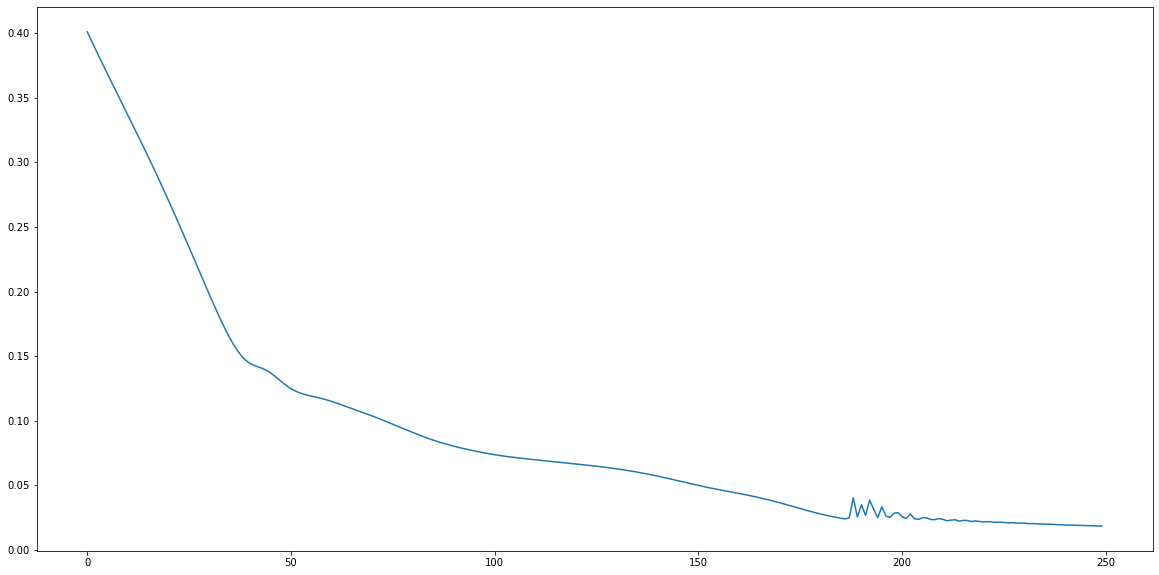

In [262]:
fig = plt.figure(figsize = (20,10))
plt.plot(train_loss_avg) 
plt.show()